In [1]:
import torch
import torchvision
from torch import nn
from torch.utils import data
from d2l import torch as d2l


class SKConv(nn.Module):
    def __init__(self, features, M=2, G=32, r=16, stride=1, L=32):

        super(SKConv, self).__init__()
        d = max(int(features / r), L)
        self.M = M
        self.features = features
        self.convs = nn.ModuleList([])
        for i in range(M):
            self.convs.append(nn.Sequential(
                nn.Conv2d(features, features, kernel_size=3, stride=stride, padding=1 + i, dilation=1 + i, groups=G,
                          bias=False),
                nn.BatchNorm2d(features),
                nn.ReLU(inplace=False)
            ))
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(nn.Conv2d(features, d, kernel_size=1, stride=1, bias=False),
                                nn.BatchNorm2d(d),
                                nn.ReLU(inplace=False))
        self.fcs = nn.ModuleList([])
        for i in range(M):
            self.fcs.append(
                nn.Conv2d(d, features, kernel_size=1, stride=1)
            )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        batch_size = x.shape[0]

        feats = [conv(x) for conv in self.convs]
        feats = torch.cat(feats, dim=1)
        feats = feats.view(batch_size, self.M, self.features, feats.shape[2], feats.shape[3])

        feats_U = torch.sum(feats, dim=1)
        feats_S = self.gap(feats_U)
        feats_Z = self.fc(feats_S)

        attention_vectors = [fc(feats_Z) for fc in self.fcs]
        attention_vectors = torch.cat(attention_vectors, dim=1)
        attention_vectors = attention_vectors.view(batch_size, self.M, self.features, 1, 1)
        attention_vectors = self.softmax(attention_vectors)

        feats_V = torch.sum(feats * attention_vectors, dim=1)

        return feats_V


class SKUnit(nn.Module):
    def __init__(self, in_features, mid_features, out_features, M=2, G=32, r=16, stride=1, L=32):

        super(SKUnit, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features, mid_features, 1, stride=1, bias=False),
            nn.BatchNorm2d(mid_features),
            nn.ReLU(inplace=True)
        )

        self.conv2_sk = SKConv(mid_features, M=M, G=G, r=r, stride=stride, L=L)

        self.conv3 = nn.Sequential(
            nn.Conv2d(mid_features, out_features, 1, stride=1, bias=False),
            nn.BatchNorm2d(out_features)
        )

        if in_features == out_features:  # when dim not change, in could be added diectly to out
            self.shortcut = nn.Sequential()
        else:  # when dim not change, in should also change dim to be added to out
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_features, out_features, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_features)
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.conv2_sk(out)
        out = self.conv3(out)

        return self.relu(out + self.shortcut(residual))


class SKNet(nn.Module):
    def __init__(self, class_num, nums_block_list=[3, 4, 6, 3], strides_list=[1, 2, 2, 2]):
        super(SKNet, self).__init__()
        self.basic_conv = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.maxpool = nn.MaxPool2d(3, 2, 1)

        self.stage_1 = self._make_layer(64, 128, 128, nums_block=nums_block_list[0], stride=strides_list[0])
        self.stage_2 = self._make_layer(128, 256, 512, nums_block=nums_block_list[1], stride=strides_list[1])
        self.stage_3 = self._make_layer(512, 512, 1024, nums_block=nums_block_list[2], stride=strides_list[2])
        self.stage_4 = self._make_layer(1024, 1024, 2048, nums_block=nums_block_list[3], stride=strides_list[3])

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(2048, class_num)

    def _make_layer(self, in_feats, mid_feats, out_feats, nums_block, stride=1):
        layers = [SKUnit(in_feats, mid_feats, out_feats, stride=stride)]
        for _ in range(1, nums_block):
            layers.append(SKUnit(out_feats, mid_feats, out_feats))
        return nn.Sequential(*layers)

    def forward(self, x):
        fea = self.basic_conv(x)
        fea = self.maxpool(fea)
        fea = self.stage_1(fea)
        fea = self.stage_2(fea)
        fea = self.stage_3(fea)
        fea = self.stage_4(fea)
        fea = self.gap(fea)
        fea = torch.squeeze(fea)
        fea = self.classifier(fea)
        return fea


def SKNet26(nums_class=100):
    return SKNet(nums_class, [2, 2, 2, 2])


def SKNet50(nums_class=100):
    return SKNet(nums_class, [3, 4, 6, 3])


def SKNet101(nums_class=100):
    return SKNet(nums_class, [3, 4, 23, 3])

In [2]:
def load_data_cifar100(batch_size=128):
    transform_train = torchvision.transforms.Compose([
        # torchvision.transforms.Resize(256),
        # torchvision.transforms.CenterCrop(224),
        torchvision.transforms.Resize(40),
        torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                 ratio=(1.0, 1.0)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                         [0.2023, 0.1994, 0.2010])])

    transform_test = torchvision.transforms.Compose([
        # torchvision.transforms.Resize(256),
        # torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                         [0.2023, 0.1994, 0.2010])])

    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                             download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=0)

    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                            download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=0)
    return trainloader, testloader


def train_batch(net, X, y, loss, trainer, devices):
    X = X.to(devices)
    y = y.to(devices)
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum


def train(net, train_iter, valid_iter, num_epochs, loss, trainer, lr_period,
          lr_decay, use_sl=True, device=d2l.try_gpu()):
    if use_sl:
        scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = net.to(device)
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(net, features, labels, loss,
                                 trainer, device)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[2], None))
        if valid_iter is not None:
            valid_acc = evaluate_accuracy(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        if use_sl:
            scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
                     f' examples/sec')


def evaluate_accuracy(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]


def train_fine_tuning(net, learning_rate, lr_period, lr_decay, train_iter, valid_iter, loss, num_epochs=5,
                      param_group=True):
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                  lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    train(net, train_iter, valid_iter, num_epochs, loss, trainer, lr_period, lr_decay)


train loss 0.083, train acc 0.977, valid acc 0.378
1383.7 examples/sec


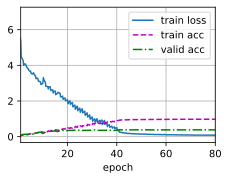

In [3]:
net = SKNet50(100)
devices = d2l.try_gpu()
num_epochs = 80
lr = 2e-4
wd = 5e-4
lr_period = 40
lr_decay = 0.1
trainloader, validloader = load_data_cifar100()
loss = nn.CrossEntropyLoss(reduction="none")
trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
train(net, trainloader, validloader, num_epochs, loss, trainer, lr_period, lr_decay)
torch.save(net.state_dict(), "sknet.pth", _use_new_zipfile_serialization=True)